Implementing the unsupervised training of Matryoshka-Adaptors <br/>
With the currently set parameters, the code trains on the SciFact corpus using the unsupervised objectve. <br/>
Afterwards, the adaptor's retrieval performance is evaluated on the SciFact test dataset. <br/>
Note: You can instead train on MSMARCO by setting: tr_dataset_name = "msmarco"

In [1]:
from beir import util, LoggingHandler
from beir.datasets.data_loader import GenericDataLoader
from sentence_transformers import SentenceTransformer

import torch
import torch.optim as optim
from torch import nn

import numpy as np
import os

import faiss
import random
import mteb
from mteb import MTEB
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

from typing import Dict, Union

/home/skunk/.conda/envs/LLMs/lib/python3.9/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# setting the random seed to improve reproducibility
random_seed = 0

python_random = random.Random(random_seed)
torch.manual_seed(random_seed)

### Hyperparameters

In [3]:
# Most hyperparameters are copied from Appendix B of the paper

base_encoder = "sentence-transformers/all-MiniLM-L6-v2"
embedding_dim = 384
m_values = [64, 128, 256, 384]

# Matryoshka Adaptor hyperparameters
ma_hidden_dim = 1024

# Training hyperparameters
tr_dataset_name = "scifact"
max_num_tr_datapoints = 50000

k = 5 # number of nearest neighbours
batch_size = 128
optimizer_fn = lambda params: optim.Adam(params, lr=0.001)
patience = 500
max_tr_iterations = 5000

# Evaluation parameters
eval_dataset_name = "scifact"

device = "cuda" if torch.cuda.is_available() else "cpu"

### Adaptor Model

In [4]:
class SwiGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(SwiGLU, self).__init__()
        self.linear_1 = nn.Linear(dim_in, dim_out)
        self.linear_2 = nn.Linear(dim_in, dim_out)
    
    def forward(self, x):
        # First linear projection followed by SiLU (Sigmoid Linear Unit)
        x1 = torch.nn.functional.silu(self.linear_1(x))
        # Second linear projection
        x2 = self.linear_2(x)
        # Element-wise multiplication
        return x1 * x2

class MatryoshkaAdaptor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(MatryoshkaAdaptor, self).__init__()
        self.layer1 = SwiGLU(embedding_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x: Union[torch.Tensor, Dict[str, torch.Tensor]]):
        if isinstance(x, Dict):
            inputs = x["sentence_embedding"]
        else:
            inputs = x            

        out = self.layer1(inputs)
        out = self.layer2(out)
        out = out + inputs  # Skip connection
        
        if isinstance(x, Dict):
            x["sentence_embedding"] = out
            return x
        else:
            return out

## Data Prep Functions

In [5]:
def load_and_preprocess_data(dataset_name, model_name, batch_size=512):
    # 1) Load the BEIR dataset
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
    data_path = util.download_and_unzip(url, f"./datasets/{dataset_name}")
    corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="train")

    corpus_keys = list(corpus.keys())
    if len(corpus) > max_num_tr_datapoints:
        corpus_keys = python_random.sample(corpus_keys, max_num_tr_datapoints)
    
    print(f"Num training data points : {len(corpus_keys)}")
    
    # 2) Load a sentence transformer model
    model = SentenceTransformer(model_name)
    model = model.to(device)
    
    # 3) Process the corpus into embeddings
    corpus_texts = [corpus[doc_id]['text'] for doc_id in corpus_keys]
    corpus_embeddings = model.encode(corpus_texts, convert_to_numpy=False,
                                     show_progress_bar=True, batch_size=batch_size)
    # Convert list of tensors to a single tensor
    corpus_embeddings = torch.stack(corpus_embeddings)
    
    # 4) Unload the dataset and model from memory
    del corpus
    del model
    torch.cuda.empty_cache()

    # 5) Return the embeddings
    return corpus_embeddings

In [6]:
def compute_knn_cosine(embeddings: torch.Tensor, k=5):
    embeddings = embeddings.cpu().numpy()
    # 1) Ensure the embeddings are in float32 format as required by FAISS
    embeddings = np.array(embeddings, dtype=np.float32)
    
    # 2) Initialize FAISS index (Inner Product)
    d = embeddings.shape[1]  # Dimension of the embeddings
    index = faiss.IndexFlatIP(d)  # Flat index for Inner Product (dot product)
    
    # 3) Add embeddings to the FAISS index
    index.add(embeddings)
    
    # 4) Perform k-nearest neighbor search for k+1 neighbors to include self-match
    distances, indices = index.search(embeddings, k + 1)
    
    # 5) Remove the first neighbor (which is the item itself)
    indices = indices[:, 1:]  # Remove the first column (self-match)
    
    # 6) Return the indices of the k-nearest neighbors (shape: N x k)
    return indices


### Matryoshka-Adaptor Losses

In [7]:
def loss_rec(embeddings, transformed_embeddings):
    # implementing L_rec (Eq. 3)
    
    # normalize the transformed_embeddings to length 1
    transformed_embeddings_normalized = torch.nn.functional.normalize(transformed_embeddings, p=2, dim=1)
    
    batch_size = embeddings.shape[0]
    # Can change: Do I divide by (batch_size * num_dimensions), or only batch_size
    return torch.abs(embeddings - transformed_embeddings_normalized).mean()

In [8]:
def loss_pair(embeddings, transformed_embeddings):
    batch_size = embeddings.shape[0]
    
    # getting the upper triangle of a symmtric matrix to avoid redundancy
    upper_triangle_embeddings_similarities = torch.triu((embeddings @ embeddings.T), diagonal=0)

    loss_pair = 0.
    for m in m_values:
        c_transformed_embeddings = transformed_embeddings[:, :m]
        # normalize the truncated embeddings
        c_transformed_embeddings = torch.nn.functional.normalize(c_transformed_embeddings, p=2, dim=1)
        
        upper_triangle_matryoshka_embeddings_similarities = torch.triu((c_transformed_embeddings@c_transformed_embeddings.T), diagonal=0)
        loss_pair += torch.abs(upper_triangle_embeddings_similarities - upper_triangle_matryoshka_embeddings_similarities)

    # normalize by batch_size * num_dimensions 
    # Decision atm: don't divide by len(m_values) since all of these could be seen as a different loss of equal importance to loss_rec
    loss_pair = loss_pair.sum() / batch_size
    
    return loss_pair

In [9]:
def loss_knn(embeddings, knn_embeddings, transformed_embeddings, transformed_knn_embeddings):
    # embeddings.shape = (batch.size, embedding_size)
    # knn_embeddings.shape = (batch,size, k, embedding_size)
    # transformed_embeddings.shape = (batch_size, embedding_size)
    # transformed_knn_embeddings.shape = (batch_size, k, embedding_size)
    
    # compute the similarities between original embeddings and their k-nearest-neighbours
    embeddings_similarities = torch.sum(embeddings.unsqueeze(1) * knn_embeddings, dim=-1)  # shape = (batch_size, k)

    loss_knn = 0.
    for m in m_values:
        # extract the first m dimensions
        c_transformed_embeddings = transformed_embeddings[:, :m]
        # normalize the truncated embeddings
        c_transformed_embeddings = torch.nn.functional.normalize(c_transformed_embeddings, p=2, dim=1)

        # do the same for the knn
        c_transformed_knn_embeddings = transformed_knn_embeddings[:, :, :m]
        c_transformed_knn_embeddings = torch.nn.functional.normalize(c_transformed_knn_embeddings, p=2, dim=2)

        c_transformed_embeddings_similarities = torch.sum(c_transformed_embeddings.unsqueeze(1) * c_transformed_knn_embeddings, dim=-1)  # shape = (batch_size, k)

        loss_knn += torch.abs(embeddings_similarities - c_transformed_embeddings_similarities)
    loss_knn = loss_knn.sum() / (batch_size * k)
    return loss_knn

### Training

In [10]:
def training_loop(embeddings, knn_indices, matryoshka_adaptor,
                  optimizer, batch_size, k, max_tr_iterations, patience):
    """
    Training loop that iterates through all embeddings in batches for a given number of epochs
    with early stopping and a maximum number of iterations.
    
    Args:
    - embeddings: A tensor of shape (N, D), where N is the number of embeddings and D is the dimension.
    - knn_indices: A tensor of shape (N, k), containing indices of the k-nearest neighbors for each embedding.
    - matryoshka_adaptor: The matryoshka_adaptor to train (e.g., MatryoshkaAdaptor).
    - optimizer: The optimizer for the modelmatryoshka_adaptor.
    - batch_size: The number of embeddings to process in each batch.
    - k: The number of nearest neighbors to retrieve.
    - num_epochs: Maximum number of epochs to train.
    - max_tr_iterations: Maximum number of training iterations (batches) to train.
    - patience: Number of epochs with no improvement to wait for early stopping.
    """
    
    N, D = embeddings.shape  # N: number of embeddings, D: dimension of each embedding
    
    best_loss = float('inf')  # Initialize best loss as infinity
    epochs_without_improvement = 0  # Counter for epochs without loss improvement
    total_iterations = 0  # Counter for total iterations

    epoch = 0
    
    # Iterate through epochs
    while total_iterations < max_tr_iterations:
        print(f"Epoch {epoch + 1}")
        
        # Shuffle the indices at the start of each epoch
        indices = torch.randperm(N)
        
        epoch_loss = 0.0  # Track total loss for the epoch
        
        # Iterate through all embeddings in batches
        for i in range(0, N, batch_size):
            if total_iterations >= max_tr_iterations:
                print("Reached maximum number of iterations. Stopping training.")
                break
            
            # Select a batch of embeddings
            batch_indices = indices[i:i + batch_size]
            batch_embeddings = embeddings[batch_indices]  # Embedding matrix A of size (batch_size, D)
            
            # Retrieve the k-nearest neighbors for the selected batch
            batch_knn_indices = knn_indices[batch_indices]  # Get k-nearest neighbor indices for the selected batch
            batch_knn_embeddings = embeddings[batch_knn_indices]  # Embedding matrix of size (batch_size, k, D)
            
            # Forward pass
            optimizer.zero_grad()
            # process the current batch_embeddings
            matryoshka_embeddings = matryoshka_adaptor(batch_embeddings)  # Forward pass for the selected batch embeddings
            # Compute the loss between the matryoshka_adaptor's output and the nearest neighbors (example MSE loss)
            loss = 0.
            loss += loss_rec(batch_embeddings, matryoshka_embeddings)
            loss += loss_pair(batch_embeddings, matryoshka_embeddings)
            
            # process the batch_embedding's nearest neighbours (Note: This could be combined into 1 , instead of 2 forward passes, if necessary)
            batch_knn_embeddings_flattened = batch_knn_embeddings.view(-1, embedding_dim)
            batch_knn_embeddings_processed = matryoshka_adaptor(batch_knn_embeddings_flattened)
            batch_knn_embeddings_processed = batch_knn_embeddings_processed.view(batch_indices.shape[0], k, embedding_dim)
            loss += loss_knn(batch_embeddings, batch_knn_embeddings, matryoshka_embeddings, batch_knn_embeddings_processed)
            
            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()  # Accumulate loss
            total_iterations += 1  # Increment total iterations
            
        epoch_loss /= (N // batch_size)  # Average loss for the epoch
        
        print(f"End of epoch {epoch + 1}: Loss = {epoch_loss}")

        # Check for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_without_improvement = 0  # Reset patience counter
        else:
            epochs_without_improvement += 1  # Increment patience counter
        
        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"No improvement for {patience} consecutive epochs. Stopping training.")
            break

        epoch += 1

In [11]:
# Load + Preprocess training data
corpus_embeddings = load_and_preprocess_data(tr_dataset_name, base_encoder)
# normalize s.t. each embedding is of length 1 (note: they might already be, just making sure)
corpus_embeddings = torch.nn.functional.normalize(corpus_embeddings, p=2, dim=1)
print(f"corpus_embeddings.shape = {corpus_embeddings.shape}")

  0%|          | 0/5183 [00:00<?, ?it/s]

Num training data points : 5183


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

corpus_embeddings.shape = torch.Size([5183, 384])


In [12]:
# Compute KNN
corpus_embeddings_knn_indices = compute_knn_cosine(corpus_embeddings, k=k)
print(f"corpus_embeddings_knn_indices.shape = {corpus_embeddings_knn_indices.shape}")
corpus_embeddings_knn_indices_torch = torch.from_numpy(corpus_embeddings_knn_indices)

corpus_embeddings_knn_indices.shape = (5183, 5)


In [13]:
# Create the Matryoshka Adaptor
matryoshka_adaptor = MatryoshkaAdaptor(embedding_dim, ma_hidden_dim).to(device)
optimizer = optimizer_fn(matryoshka_adaptor.parameters())

In [14]:
# Train the Adaptor
training_loop(corpus_embeddings, corpus_embeddings_knn_indices_torch, matryoshka_adaptor,
                  optimizer, batch_size, k, max_tr_iterations, patience)

Epoch 1
End of epoch 1: Loss = 12.499300420284271
Epoch 2
End of epoch 2: Loss = 9.980272543430328
Epoch 3
End of epoch 3: Loss = 8.894279599189758
Epoch 4
End of epoch 4: Loss = 8.15582379102707
Epoch 5
End of epoch 5: Loss = 7.560039818286896
Epoch 6
End of epoch 6: Loss = 7.186726158857345
Epoch 7
End of epoch 7: Loss = 6.87474964261055
Epoch 8
End of epoch 8: Loss = 6.585655003786087
Epoch 9
End of epoch 9: Loss = 6.414237821102143
Epoch 10
End of epoch 10: Loss = 6.212537789344788
Epoch 11
End of epoch 11: Loss = 6.067701625823974
Epoch 12
End of epoch 12: Loss = 5.954874503612518
Epoch 13
End of epoch 13: Loss = 5.890150225162506
Epoch 14
End of epoch 14: Loss = 5.772283238172531
Epoch 15
End of epoch 15: Loss = 5.690545719861984
Epoch 16
End of epoch 16: Loss = 5.596325606107712
Epoch 17
End of epoch 17: Loss = 5.608816564083099
Epoch 18
End of epoch 18: Loss = 5.549145096540451
Epoch 19
End of epoch 19: Loss = 5.4495001316070555
Epoch 20
End of epoch 20: Loss = 5.37197350859642

### Save / Load the model

In [15]:
# file_path = 'matryoshka_adaptor_scifact.pth'
# torch.save(matryoshka_adaptor.state_dict(), file_path)
# matryoshka_adaptor = MatryoshkaAdaptor(embedding_dim, ma_hidden_dim).to(device)
# matryoshka_adaptor.load_state_dict(torch.load(file_path))

# Evaluations

In [16]:
# Custom SentenceTransformer child class with an adaptor
class SentenceTransformerwMatryoskaAdaptor(SentenceTransformer):
    def __init__(self, base_model_name: str, adaptor: torch.nn.Module):
        """
        Initialize the custom SentenceTransformer with a base model and an adaptor.
        
        Args:
        - base_model_name: Name of the pre-trained base model (e.g., 'paraphrase-MiniLM-L6-v2').
        - adaptor: A neural network module that processes the embeddings from the base model.
        """
        super().__init__(base_model_name)  # Initialize the base SentenceTransformer
        self.adaptor = adaptor  # Set the adaptor

In [17]:
# Initialize the benchmark
MTEB_task_name_map = {
    "scifact": "SciFact",
    "msmarco": "MSMARCO"
}
tasks = mteb.get_tasks(tasks=[MTEB_task_name_map[eval_dataset_name]])
benchmark = MTEB(tasks=tasks)

# Evaluate Baseline

In [18]:
# Get the baseline's performance at 
# m_values
baseline_results_diff_m_values = []
model = SentenceTransformer(base_encoder)

for m_value in m_values:
    model.truncate_dim = m_value
    # Run the evaluation
    baseline_results_diff_m_values.append(benchmark.run(model, output_folder=None))
del model

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [19]:
baseline_y_values = [
    bres[0].scores["test"][0]["ndcg_at_10"]
    for bres in baseline_results_diff_m_values
]

# Evaluate the Matryoshka Adaptor

In [20]:
matr_adaptor_results_diff_m_values = []
model = SentenceTransformerwMatryoskaAdaptor(base_encoder, adaptor=matryoshka_adaptor)

for m_value in m_values:
    model.truncate_dim = m_value
    # Run the evaluation
    matr_adaptor_results_diff_m_values.append(benchmark.run(model, output_folder=None))
del model

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [21]:
matr_adaptor_y_values = [
    mres[0].scores["test"][0]["ndcg_at_10"]
    for mres in matr_adaptor_results_diff_m_values
]

### Plot Results

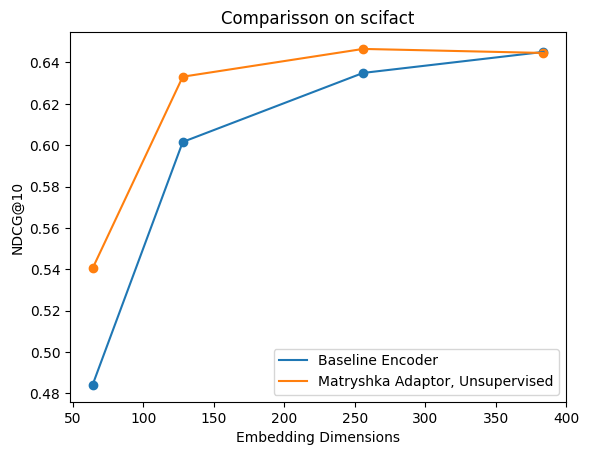

In [25]:
# 3 losses with SwiGLU adaptor
plt.title(f"Comparison on {eval_dataset_name}")
plt.xlabel("Embedding Dimensions")
plt.ylabel("NDCG@10")

plt.plot(m_values, baseline_y_values, label="Baseline Encoder")
plt.scatter(m_values, baseline_y_values)

plt.plot(m_values, matr_adaptor_y_values, label="Matryshka Adaptor, Unsupervised")
plt.scatter(m_values, matr_adaptor_y_values)

plt.legend()